# **Simulações**


In [1]:
# Bibliotecas
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import joblib

# Verificando quais alunos evadiram
def verifica_evadidos(row):
    if pd.isna(row['PONTO_VIRADA_2022']):  # Se PONTO_VIRADA_2022 for NaN
        return True  # O aluno evadiu
    elif pd.isna(row['PONTO_VIRADA_2020']):  # Se PONTO_VIRADA_2020 for NaN
        return False  # O aluno não evadiu
    elif pd.isna(row['PONTO_VIRADA_2021']):  # Se PONTO_VIRADA_2021 for NaN
        return True  # O aluno evadiu
    else:
        return False  # O aluno não evadiu

# Função para identificar o último ano de ponto de virada antes de NaN
def ultimo_ano(row):
    if row['EVADIU']:  # Verifica se EVADIU é verdadeiro
        if row['PONTO_VIRADA_2020'] in ['Sim', 'Não'] and pd.isna(row['PONTO_VIRADA_2021']):
            return 2020
        elif row['PONTO_VIRADA_2021'] in ['Sim', 'Não'] and pd.isna(row['PONTO_VIRADA_2022']):
            return 2021
        elif row['PONTO_VIRADA_2022'] in ['Sim', 'Não']:
            return 2022
    return pd.NA

def _generate_df_evasao(df):
    indicacao_evasao = ['NOME', 'PONTO_VIRADA_2020', 'PONTO_VIRADA_2021', 'PONTO_VIRADA_2022']
    df_evasao = df[indicacao_evasao]
    df_evasao['EVADIU'] = df_evasao.apply(verifica_evadidos, axis=1)
    # Aplicar a função para cada linha do DataFrame
    df_evasao['ULTIMO_ANO'] = df_evasao.apply(ultimo_ano, axis=1)
    return df_evasao

def _df_passos_magicos():
    df = pd.read_csv('data/raw/PEDE_PASSOS_DATASET_FIAP.csv', sep=';')
    df_evasao = _generate_df_evasao(df)
    # Mesclar os DataFrames com base na coluna 'NOME'
    df = df.merge(df_evasao[['NOME', 'EVADIU', 'ULTIMO_ANO']], on='NOME', how='left')
    # removendo linha problematica
    df = df.loc[~(df['INDE_2020'] == 'D980')]
    # substituindo null estranho
    df.loc[(df['INDE_2021'] == '#NULO!'),['INDE_2021']] = np.nan

    return df

def _get_saresp():
    return pd.read_csv('../data/processed/saresp.csv')

def _rename(df, cols_not_rename=['YEAR'], posfixo='_Y-1'):
    for col in cols_not_rename:
        df[col] = df[col].astype(str)
    for col in list(set(df.columns) - set(cols_not_rename)):
        df = df.rename(columns={col:col+posfixo})
    return df

def _get_xgb_model(path='models/xgb_model.pkl'):
    return joblib.load(path)


In [2]:
model = _get_xgb_model(path='../models/xgb_model.pkl')

In [3]:
model[:-1].get_feature_names_out()

array(['num__INDE_Y', 'num__PORC_PONTOS_LP_MAX_Y', 'num__INDE_Y-1',
       'num__PORC_PONTOS_MAT_STD_Y', 'num__PORC_PONTOS_MAT_MIN_Y-1',
       'num__IPP_Y', 'num__IEG_Y', 'num__IPV_Y-1',
       'num__PORC_PONTOS_MAT_STD_Y-1', 'num__PORC_PONTOS_LP_MIN_Y-1',
       'num__PORC_PONTOS_LP_MEDIAN_Y-1', 'num__IAN_Y',
       'num__TOTAL_PONTOS_LP_MEAN_Y-1', 'num__IDA_Y-1',
       'num__PORC_PONTOS_LP_MIN_Y', 'num__TOTAL_PONTOS_LP_STD_Y-1',
       'num__TOTAL_PONTOS_LP_MAX_Y-1', 'num__TOTAL_PONTO_MAT_MEDIAN_Y-1',
       'num__IAA_Y', 'num__IDADE_Y', 'num__PORC_PONTOS_MAT_MAX_Y',
       'num__TOTAL_PONTO_MAT_STD_Y-1', 'num__TOTAL_PONTOS_LP_MAX_Y',
       'num__TOTAL_PONTO_MAT_MEAN_Y', 'num__TOTAL_PONTO_MAT_MEDIAN_Y',
       'num__IAN_Y-1', 'num__TOTAL_PONTOS_LP_MIN_Y',
       'num__TOTAL_PONTOS_LP_STD_Y', 'num__IAA_Y-1', 'num__IEG_Y-1',
       'num__IPP_Y-1', 'num__PORC_PONTOS_MAT_MEAN_Y',
       'num__PORC_PONTOS_MAT_MEDIAN_Y', 'num__TOTAL_PONTOS_LP_MIN_Y-1',
       'num__TOTAL_PONTOS_LP_MEAN_

In [4]:
def _test_df_cols(df):
    cols_in_last_year =  ['IDADE_Y-1', 'IAA_Y-1', 'IAN_Y-1', 'IDA_Y-1', 'IEG_Y-1', 'INDE_Y-1', 'IPP_Y-1', 'IPS_Y-1', 'IPV_Y-1']
    cols_in_current_year =  ['IDADE_Y', 'IAA_Y', 'IAN_Y', 'IDA_Y', 'IEG_Y', 'INDE_Y', 'IPP_Y', 'IPS_Y', 'IPV_Y']
    cols_identity = ['YEAR','NOME']
    cols_diff = set(cols_in_current_year + cols_in_last_year + cols_identity).difference(df.columns)
    return {
          'cols_diff':cols_diff
        , 'status_ok':True if len(cols_diff)<1 else False
        , 'df':df
    }

In [5]:
def _load_new_data(file_path):
    df = pd.read_excel(file_path)
    cols_in =  ['IDADE', 'IAA', 'IAN', 'IDA', 'IEG', 'INDE', 'IPP', 'IPS', 'IPV']
    if not(_test_df_cols(df)['status_ok']):
        return _test_df_cols(df)
    
    # add dados da saresp em Y-1
    df_saresp = _get_saresp()
    df_saresp_m1 = _rename(df_saresp, posfixo='_Y-1')
    for col in ['YEAR','IDADE_Y-1']:
        df_saresp_m1[col] = df_saresp_m1[col].astype(int)
        df[col] = df[col].astype(int)
    df = df.merge(
        df_saresp_m1
        , on=['YEAR','IDADE_Y-1']
        )
    
    # saresp no ano corrente
    df_saresp_m = _rename(df_saresp, posfixo='_Y')
    for col in ['YEAR','IDADE_Y']:
        df_saresp_m[col] = df_saresp_m[col].astype(int)
        df[col] = df[col].astype(int)
    df = df.merge(
        df_saresp_m
        , on=['YEAR','IDADE_Y']
        )
    return {
          'cols_diff':[]
        , 'status_ok':True
        , 'df':df
    }


In [6]:
response_new_data = _load_new_data('../data/processed/dado_simulacao.xlsx')
if (response_new_data['status_ok']):
    df_new_data = response_new_data['df']
else:
    print(response_new_data)

In [7]:
import shap
import warnings

feature_cols = list(set(df_new_data).difference(['YEAR','NOME']))
explainer = shap.TreeExplainer(model['model'])
shap_values = explainer(df_new_data[feature_cols])
expected_value = explainer.expected_value
if isinstance(expected_value, list):
    expected_value = expected_value[1]
print(f"Explainer expected value: {expected_value}")

Explainer expected value: [-0.28570214]


In [8]:
_response = {
    'X':df_new_data
}

In [9]:
def f(x):
    return np.log(x/(1-x))
def finv(x):
    return 1/(1+np.exp(-x))


In [10]:
shap_values.sum()

.values =
-97.71721947919573

.base_values =
array([-0.28570214, -0.28570214, -0.28570214, -0.28570214, -0.28570214,
       -0.28570214, -0.28570214, -0.28570214, -0.28570214, -0.28570214,
       -0.28570214, -0.28570214, -0.28570214, -0.28570214, -0.28570214,
       -0.28570214, -0.28570214, -0.28570214, -0.28570214, -0.28570214,
       -0.28570214, -0.28570214, -0.28570214, -0.28570214, -0.28570214,
       -0.28570214, -0.28570214, -0.28570214])

.data =
nan

In [11]:
import plotly.express as px
import plotly.graph_objs as go

fig = go.Figure()
feature_cols = list(set(df_new_data).difference(['YEAR','NOME']))
for _name in df_new_data.NOME.unique():

    _internal_data = df_new_data.loc[df_new_data.NOME == _name]

    explainer = shap.TreeExplainer(model['model'])
    shap_values = explainer(_internal_data[feature_cols]).values
    expected = (explainer.expected_value[0])
    shap_interaction_values = explainer.shap_interaction_values(_internal_data[feature_cols])[0]
    
    cumsum = expected + np.nancumsum(shap_values)
    
    fig.add_trace(
        go.Scatter(
            x = finv(cumsum.astype(float)),
            y = feature_cols,
            mode='lines',
            name=f"{_name}-sum{finv(cumsum.astype(float)).sum()} - y_pred={str(model.predict(_internal_data[feature_cols])[0])} - proba={round(model.predict_proba(_internal_data[feature_cols])[0][1],2)}",
        )
    )
# fig.add_vline(x=expected)
fig.update_layout(
    autosize=False,
    width=800,
    height=len(feature_cols)*20,
)
fig.show()

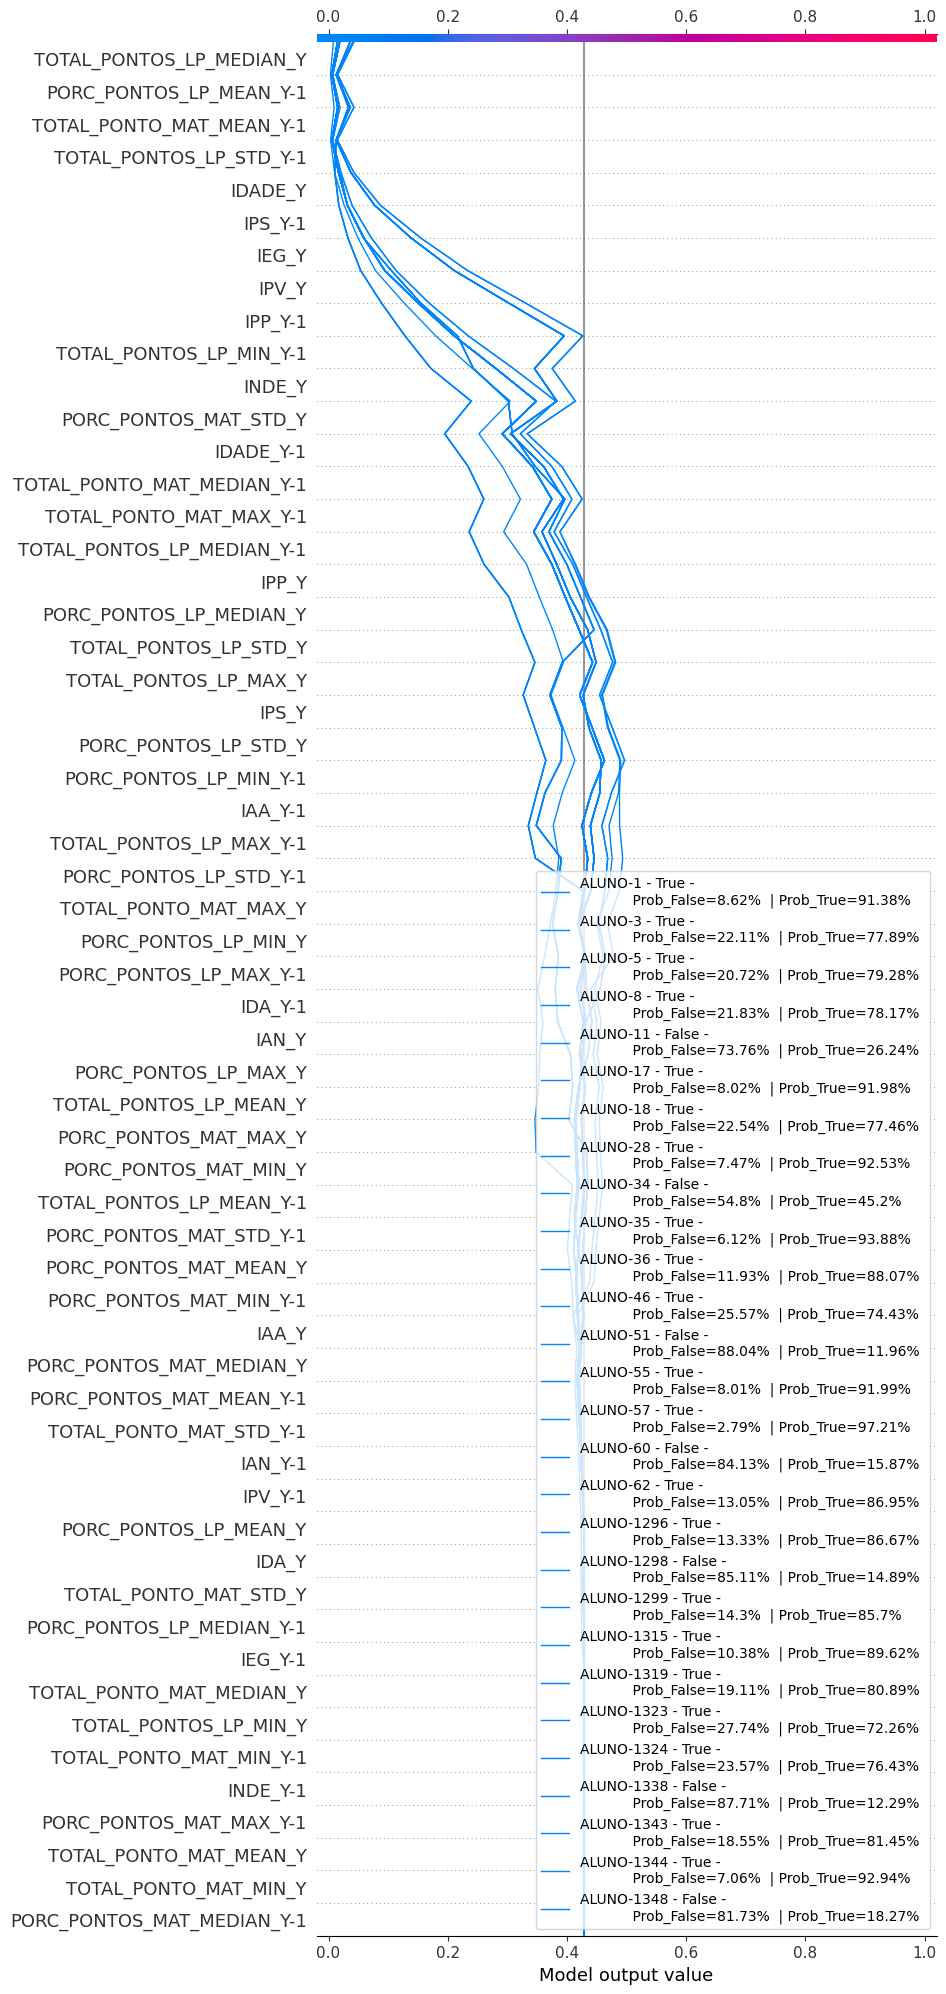

In [12]:
shap.initjs()
def create_legend(df, model):
    if not(type(df)==pd.core.series.Series):
        return [f"""{x.NOME} - {model.predict(pd.DataFrame(x).T)[0]} - 
            Prob_False={round(model.predict_proba(pd.DataFrame(x).T)[0][0]*100,2)}%  | Prob_True={round(model.predict_proba(pd.DataFrame(x).T)[0][1]*100,2)}% """ for i, x in df.iterrows()]
    else:
        return [f"""{df.NOME} - {model.predict(pd.DataFrame(df).T)[0]} - 
            Prob_False={round(model.predict_proba(pd.DataFrame(df).T)[0][0]*100,2)}%  | Prob_True={round(model.predict_proba(pd.DataFrame(df).T)[0][1]*100,2)}% """]

idx = 9
y_pred = model.predict(df_new_data)
expected = model.predict_proba(df_new_data)[1]

shap.decision_plot(
    explainer.expected_value, explainer.shap_values(df_new_data[feature_cols]), df_new_data.loc[:, feature_cols], 
    link="logit",
    legend_labels=create_legend(df_new_data, model),
    legend_location="lower right",
    feature_display_range=slice(None, None, -1),
)

explainer dashboard

In [13]:
model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['INDE_Y',
                                                   'PORC_PONTOS_LP_MAX_Y',
                                                   'INDE_Y-1',
                                                   'PORC_PONTOS_MAT_STD_Y',
                                                   'PORC_PONTOS_MAT_MIN_Y-1',
                                                   'IPP_Y', 'IEG_Y', 'IPV_Y-1',
                                                   'PORC_PONTOS_MAT_STD_Y-1',
                                                   'PORC_PONTOS_LP_MIN_Y-1',
                                                   'PORC_PONTOS_LP_MEDIAN_Y-1',
                                                   'IAN_Y',...
                                                   'TOTAL_PONTOS_LP_STD_Y-1',
                                                   'TOTAL_PONTOS_LP_MAX_Y-1',
                                                   'TOTAL_PONTO_MAT_MEDIAN_Y-1',
                                                   'IAA_Y', 'IDADE_Y',
                                                   'PORC_PONTOS_MAT_MAX_Y',
                                                   'TOTAL_PONTO_MAT_STD_Y-1',
                                                   'TOTAL_PONTOS_LP_MAX_Y',
                                                   'TOTAL_PONTO_MAT_MEAN_Y',
                                                   'TOTAL_PONTO_MAT_MEDIAN_Y',
                                                   'IAN_Y-1',
                                                   'TOTAL_PONTOS_LP_MIN_Y',
                                                   'TOTAL_PONTOS_LP_STD_Y',
                                                   'IAA_Y-1', 'IEG_Y-1', ...])])),
                ('model', GradientBoostingClassifier(random_state=42))])

In [14]:
df_new_data.index = df_new_data['NOME']
df_new_data = df_new_data.drop(columns={'NOME'})

In [15]:
# https://explainerdashboard.readthedocs.io/en/latest/tabs.html

from explainerdashboard.custom import (
    ExplainerComponent, dbc, html,
    ShapDependenceComponent,
    ShapContributionsGraphComponent,
    ShapInteractionsComposite,
    IndividualPredictionsComposite,
    ClassifierPredictionSummaryComponent,
    PdpComponent
)
from explainerdashboard import ClassifierExplainer, RegressionExplainer
from explainerdashboard import ExplainerDashboard

class CustomDashboard(ExplainerComponent):
    def __init__(self, explainer, name=None, **kwargs):
        super().__init__(explainer, title="Custom Dashboard")
        self.dependence = ShapDependenceComponent(explainer,
                            hide_selector=True, hide_percentage=True,
                            cutoff=0.75, **kwargs)
        self.pdp = PdpComponent(explainer,
                            hide_selector=True, hide_cats=True,
                            hide_depth=True, hide_sort=True,
                            **kwargs)
        self.ind_preds = ShapContributionsGraphComponent(explainer,
                            hide_selector=True, hide_cats=True,
                            hide_depth=True, hide_sort=True,
                            **kwargs)
        self.class_preds = ClassifierPredictionSummaryComponent(explainer,
                            hide_selector=True, hide_cats=True,
                            hide_depth=True, hide_sort=True,
                            **kwargs)

    def layout(self):
        return dbc.Container([
            dbc.Row([
                dbc.Col([
                    html.H1("Custom Demonstration:"),
                    html.H3("How to build your own layout using ExplainerComponents.")
                ])
            ]),
            dbc.Row([
                dbc.Col([
                    self.ind_preds.layout(),
                ]),
                dbc.Col([
                    self.class_preds.layout(),
                ]),
            ]),
            dbc.Row([
                dbc.Col([
                    self.dependence.layout(),
                ]),
                dbc.Col([
                    self.pdp.layout(),
                ]),
            ])
            
        ])

explainer = ClassifierExplainer(model, df_new_data, model.predict(df_new_data))
exp_dash = ExplainerDashboard(explainer, CustomDashboard, mode='external')
exp_dash.run(8050)

splitting pipeline...
Detected sklearn/imblearn Pipeline and succesfully extracted final output dataframe with column names and final model...
Note: model_output=='probability'. For GradientBoostingClassifier shap values normally get calculated against X_background, but paramater X_background=None, so using X instead
Generating self.shap_explainer = shap.TreeExplainer(model, X, model_output='probability', feature_perturbation='interventional')...
Note: Shap interaction values will not be available. If shap values in probability space are not necessary you can pass model_output='logodds' to get shap values in logodds without the need for a background dataset and also working shap interaction values...
Building ExplainerDashboard..
Generating layout...
Calculating shap values...
Calculating dependencies...
Calculating prediction probabilities...
Calculating metrics...


d:\Cursos\FIAP_pós\gp27_techchallenge_5\.venv\lib\site-packages\dash\dash.py:550: UserWarning: JupyterDash is deprecated, use Dash instead.
See https://dash.plotly.com/dash-in-jupyter for more details.


Reminder: you can store the explainer (including calculated dependencies) with explainer.dump('explainer.joblib') and reload with e.g. ClassifierExplainer.from_file('explainer.joblib')
Registering callbacks...
Starting ExplainerDashboard on http://192.168.0.228:8050
You can terminate the dashboard with ExplainerDashboard.terminate(8050)


Dash app running on http://127.0.0.1:8050/


In [16]:
# exp_dash.terminate(8050)

Empty DataFrame
Columns: [col, contribution, value]
Index: []


d:\Cursos\FIAP_pós\gp27_techchallenge_5\.venv\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
d:\Cursos\FIAP_pós\gp27_techchallenge_5\.venv\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
d:\Cursos\FIAP_pós\gp27_techchallenge_5\.venv\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
d:\Cursos\FIAP_pós\gp27_techchallenge_5\.venv\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
d:\Cursos\FIAP_pós\gp27_techchallenge_5\.venv\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
d:\Cursos\FIAP_pós\gp27_techchallenge_5\.venv\lib\site-packages\sklearn\base.py:486: 